# Wprowadzenie do uczenia nienadzorowanego

## Literatura

Boyd  S.,  Vandenberghe  L.  (2018), Introduction  to  Applied  Linear  Algebra –Vectors,  Matrices,  and Least Squares, rozdziały: [3](http://vmls-book.stanford.edu/vmls.pdf#%5B%7B%22num%22%3A94%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C106.869%2C668.127%2Cnull%5D), [4](http://vmls-book.stanford.edu/vmls.pdf#%5B%7B%22num%22%3A107%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C106.869%2C668.127%2Cnull%5D), [5](http://vmls-book.stanford.edu/vmls.pdf#%5B%7B%22num%22%3A136%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C106.869%2C668.127%2Cnull%5D), 

## Wprowadzenie

Zwyczajowo uczenie maszynowe dzielimy na dwie kategorię: 
- <b>uczenie nadzorowane</b> 
- <b>uczenie nienadzorowane</b> 


Do klasycznych problemów uczenia nienadzorowanego możemy zaliczyć:
- klasteryzację
- wyszukiwanie obserwacji odstających
- generowanie nowych danych 
- wykrywanie zmiennych ukrytych

W ramach dzisiejszych zajęć skupimy się na pierwszym z wymienionych zagadnień.

## Klasteryzacja

Mamy zbiór $N$ wektorów, długości $n$, naszym zadaniem jest tak przyporządkować każdy z wektorów do jednej z $k$ grup aby zminimalizować wariancję wewnątrz każdej z grup i zmaksymalizować różnice między grupami.

In [14]:
Pkg.add("MLDatasets")

   Resolving package versions...
   Installed Blosc_jll ─────── v1.21.0+0
   Installed Lz4_jll ───────── v1.9.3+0
   Installed HDF5_jll ──────── v1.12.0+1
   Installed URIParser ─────── v0.4.1
   Installed Blosc ─────────── v0.7.0
   Installed BufferedStreams ─ v1.0.0
   Installed BinDeps ───────── v1.0.2
   Installed MLDatasets ────── v0.5.6
   Installed GZip ──────────── v0.5.1
   Installed DataDeps ──────── v0.7.7
   Installed HDF5 ──────────── v0.15.5
   Installed MAT ───────────── v0.10.1
    Updating `C:\Users\Vlad\.julia\environments\v1.6\Project.toml`
  [eb30cadb] + MLDatasets v0.5.6
    Updating `C:\Users\Vlad\.julia\environments\v1.6\Manifest.toml`
  [9e28174c] + BinDeps v1.0.2
  [a74b3585] + Blosc v0.7.0
  [e1450e63] + BufferedStreams v1.0.0
  [124859b0] + DataDeps v0.7.7
  [92fee26a] + GZip v0.5.1
  [f67ccb44] + HDF5 v0.15.5
  [23992714] + MAT v0.10.1
  [eb30cadb] + MLDatasets v0.5.6
  [30578b45] + URIParser v0.4.1
  [0b7ba130] + Blosc_jll v1.21.0+0
  [0234f1f7] + HDF5_jll 

In [7]:
using LinearAlgebra, StatsBase
using Clustering, Distances 
using StatsPlots
using Plots; pyplot()

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1313
┌ Warning: Module Clustering with build ID 105953062927601 is missing from the cache.
│ This may mean Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1004
┌ Info: Skipping precompilation since __precompile__(false). Importing StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd].
└ @ Base loading.jl:1021


Plots.PyPlotBackend()

In [8]:
X = vcat(0.3*randn(100,2), [1 1] .+ 0.3*randn(100,2) ,[1 -1] .+ 0.3*randn(100,2));

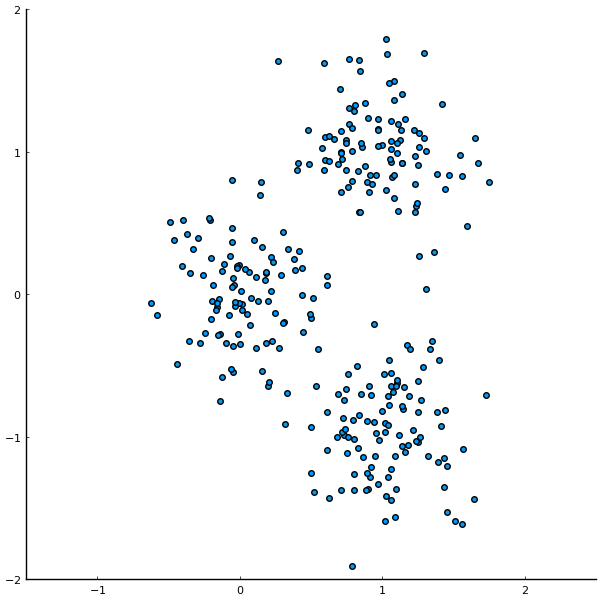

In [9]:
scatter(X[:,1], X[:,2])
plot!(legend = false, grid = false, size = (600,600),xlims = (-1.5,2.5), ylims = (-2,2))

## K-Means

Zdefiniujmy:

- Klaster - grupa wektorów $G_j$, dla $j = 1,2,\dots,k$ taka, że zawiera w sobie wszystkie obserwacje należące do danej kategorii

- wektor przyporządkowania punktów do klastra jako $C = [c_1,c_2,\dots,c_n],$ gdzie $n$ odpowiada długości wektora danych a $c_i$ oznacza, że $x_i \in G_{c_i}$

Przy tak zdefiniowanym problemie naszym zadaniem staje się  minimalizacja funkcji straty:

$J = \dfrac{1}{N}\sum^N_{i=1}||x_i - z_{c_i}||^2$

gdzie $z_{c_i}$ oznacza <b>centroid</b> (reprezentatywny punkt) danego klastra i wyznacza się je jako po prostu średnią z danego klastra:

$z_j = \frac{i}{|G_j|}\sum_{i \in G_j}x_i$

In [10]:
function kmeans(x,k,
            max_iter = 10000, 
            ϵ = 1e-9; plotting = false)
    N,n = size(x) #wymiary
    distances = zeros(N)
    centroids = zeros(k,n) 
    assigment = [rand(1:k) for i = 1:N]
    convergence = Float64[]
    iter = 1
    J_prev = Inf  
    while true
        #Wyznaczamy wartość cetroida:
        for j = 1:k
            category = x[assigment .== j, :]
            centroids[j,:] = sum(category, dims = 1)/size(category)[1]
        end
        #dopasowujemy punkty do najblizszego centroida:
        for i = 1:N
            distances_from_centroid=[LinearAlgebra.norm(x[i,:] - centroids[j,:], 2) for j = 1:k]
            distances[i], assigment[i] = findmin(distances_from_centroid)
        end
        #liczymy strate 
        J = norm(distances,2)^2 / N
        push!(convergence,J)
        if plotting
            p = scatter()
            for j = 1:k
                group = x[assigment .== j, :]
                scatter!(group[:,1], group[:,2])
            end
            scatter!(centroids[:,1], centroids[:,2],
                shape = :X, markersize  = 10)
            title = "iteration: $iter, J value: $J"
            plot!(legend = false, title = title,
                grid = false, size = (500,500),
                xlims = (-1.5,2.5), ylims = (-2,2))
            display(p)
            sleep(0.01)
        end
        (iter >= max_iter || abs(J - J_prev) < ϵ  ) && break
        J_prev = J
        iter += 1    
    end
    return assigment, centroids, convergence
end

kmeans (generic function with 3 methods)

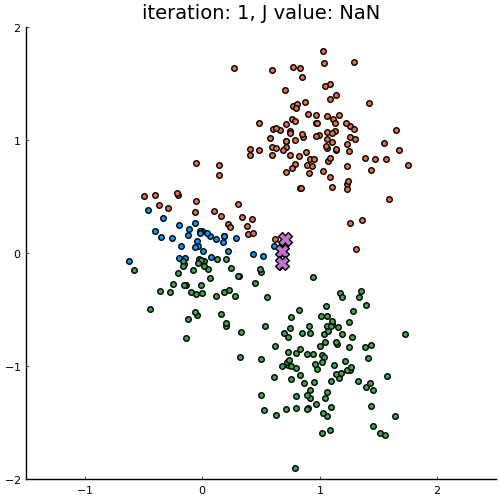

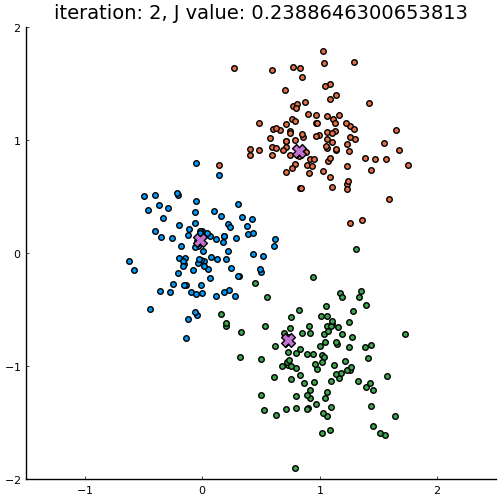

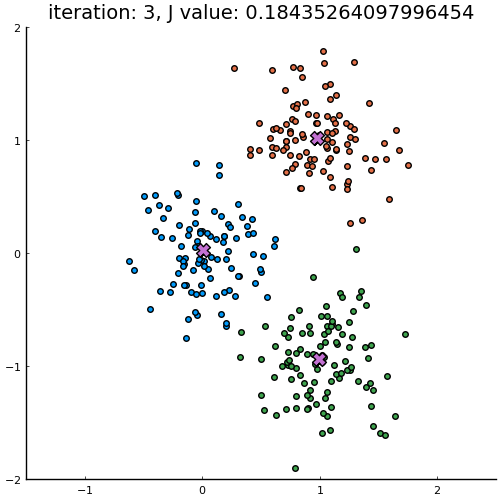

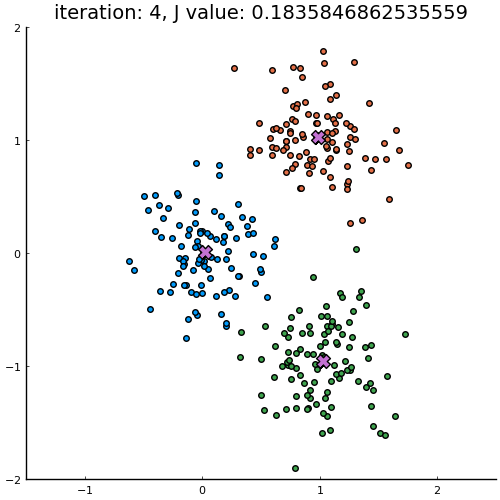

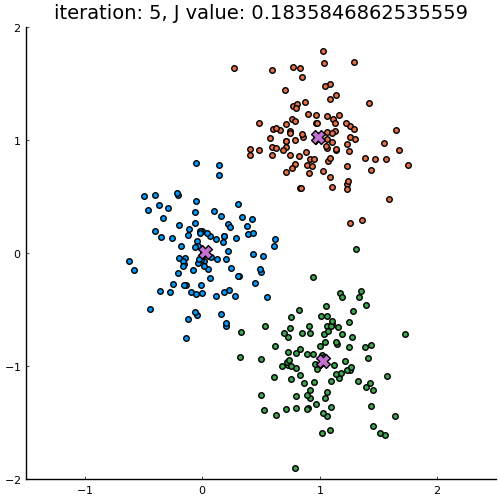

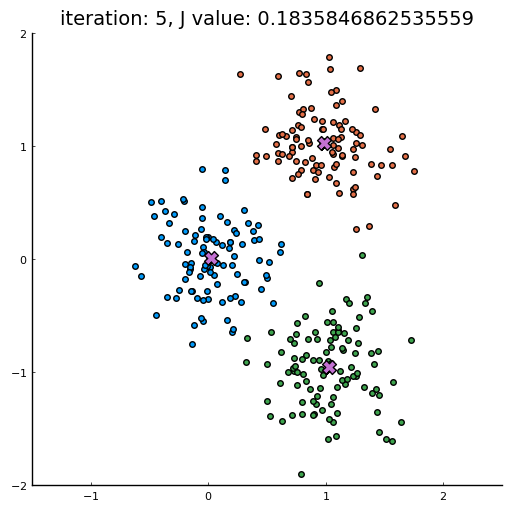

In [11]:
assigment, centroids, convergence = kmeans(X,3, plotting = true);

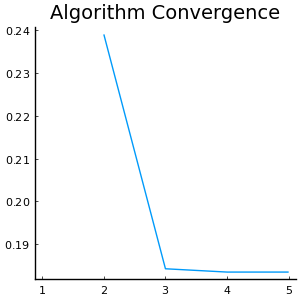

In [12]:
plot(convergence)
plot!(legend = false, title = "Algorithm Convergence",
                grid = false, size = (300,300))

Kilka właściwości:

- algorytm zawsze zbiego do rozwiązana optymalnego. Przy czym ze względu na losowy dobór obeserwacji w pierwszym kroku podział przestrzeni za każdym razem będzie inny.
- złożoność obliczeniowa wynosi $O(Nkn)$

Sprawdźmy czy nasz algorytm zadziała dla bardziej złożonego zbioru, wykorzystajmy do tego [MNISTa](http://yann.lecun.com/exdb/mnist/):

In [15]:
using MLDatasets

In [17]:
imgs, labels = MNIST.traindata(Float64)
images = reshape(imgs,(784,size(imgs,3)))[:,1:2000];
labels = labels[1:2000];

Po znalezieniu klastrów musimy ocenić czy dokonany wybór jest poprawny. W zależności od tego jakie mamy dane możemy wykorzystać do tego dwie strategie:
- bazujące na znanej z góry strukturze danych (<i>ground truth</i>)
- bazujące na własnościach (homogeniczności) otrzymanych klastrów

W przypadku gdy wiemy jaka jest <i>ground truth</i>, mamy przypisane etykiety do naszych danych możemy ocenić jakość klasteryzacji w sposób zbliżony do oceny modeli uczenia nadzorowanego. Idea takiej oceny polega na tym, że sprawdzamy czy obserwacje, które zostały przyporządkowane przez algorytm do tego samego klastra mają też w rzeczywistości taką samą etykietę. 
Do najpopularnieszych tego typu miar należą:

- <b>Rand Index (RI)</b> - jest to miara mierząca podobieństwo etykiet danych $K$ i klasteryzacji $C$ ignorująca permutacje zbioru. Jej wartość jest równa liczbie obserwacji, które mają taką samą etykietę zarówno w $K$ jak i $C$  lub różną w obu wypadkach:

$$ RI = \dfrac{a + b}{C^N_2}$$

gdzie $a$ to liczba par przypisanych do tych samych kategorii  zarówno w $K$ jak i $C$, $b$ to liczba par przypisanych do różnych kategorii w $K$ jak i $C$, a $C^N_2$ to liczba wszystkich możliwych par punktów w danym zbiorze. Przyjmuje wartości od 0 do 1, gdzie 1 oznacza doskonale dopasowaną klasteryzację a 0 całkowicie błędne przyporządkowanie kategorii.

Problemem w przypadku takiej miary jest to, że nie gwarantuje, że dla losowego przydziału kategorii wartość indeksu będzie bliska 0. <b>Adjusted Rand Index (RI)</b> jest miarą, która rozwiązuje ten problem uwzględniając losowy przydział kategorii:

$$ ARI = \dfrac{RI - E[RI]}{max(RI) - E[RI]}$$
- <b>Mutual information Index (MI)</b> - jest miarą mierzącą zgodność dwóch przyporządkowań $K$  i $C$. Intuicyjnie możemy ją interpretować jako informację na temat tego ile jesteśmy wstanie się dowiedzieć na temat jednej zmiennej losowej (w tym wypadku przyporządkowania) mając informację na temat drugiej zmiennej. Definiujemy ją następująco:

$$ MI = \sum_{i=1}^{|K|}\sum_{j=1}^{|C|}P(i,j)log(\dfrac{P(i,j)}{P(i)P(j)})$$

Podobnie jak RI informację wzajemną możemy skorygować tak aby uwzględniała wartości wynikające z w pełni losowego przyporządkowania.




Zdefiniujmy funkcję, która sprawdzi czy poprawnie klastrujemy cyfry przy założeniu, że mamy informację o kategoriach danych:

In [18]:
img(x::Vector) = Gray.(reshape(clamp.(x, 0, 1), 28, 28)')

img (generic function with 1 method)

In [19]:
function check_clustering(assigment,labels)
    cluster_labels = Int[]
    plots = []
    for i in unique(assigment)
        cat_labels = labels[assigment .== i]
        occurences, label = maximum([(count(x -> x == j, cat_labels),j) for j in unique(labels)])
        push!(cluster_labels, label)
        push!(plots,plot(img(images[:,rand(findall(x -> x == i, assigment))]), title = "Cluster: $label", 
            ticks=nothing, border=:none))
    end

    return cluster_labels, randindex(assigment,labels)[1], plots
end

check_clustering (generic function with 1 method)

In [20]:
@time assigment, centroids, convergence = kmeans(images',10);

 10.501111 seconds (2.69 M allocations: 9.672 GiB, 31.88% gc time, 7.37% compilation time)


In [21]:
cluster_labels, ARI , plots= check_clustering(assigment,labels);

In [22]:
cluster_labels

10-element Vector{Int64}:
 8
 0
 4
 1
 2
 1
 5
 3
 6
 7

In [23]:
@show ARI;

ARI = 0.3473512525619766


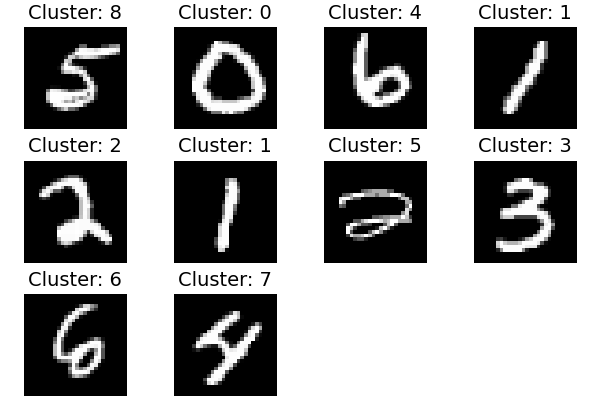

In [24]:
plot(plots...)

W sytuacjach w których nie mamy <i>ground truth</i> musimy skorzystać z jednej z wielu miar, która wykorzystuje własności otrzymanych klastrów. Do [najczęściej wykorzystywanych zaliczamy](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation):
- <b>Silhouette Index</b>
- <b>Calinski-Harabasz Index</b>
- <b>Davies-Bouldin Index</b>

In [25]:
function Davies_Bouldin(assigment,X,centroids)
    DB = 0
    s = [mean(colwise(Euclidean(),X[assigment .==i,:]',centroids[i,:])) for i in unique(assigment)] 
   for i in unique(assigment)
        R = maximum([(s[i] + s[j])/ Euclidean()(centroids[i,:],centroids[j,:]) for j in unique(assigment) if j ≠ i])
        DB += R
    end
    return DB/length(unique(assigment))
end

Davies_Bouldin (generic function with 1 method)

In [26]:
Davies_Bouldin(assigment,images',centroids)

2.703560718252298

In [27]:
DBs = []
for k = 2:20
    assigment, centroids, _ = kmeans(images',k, plotting = false);
    push!(DBs, Davies_Bouldin(assigment, images', centroids))
end

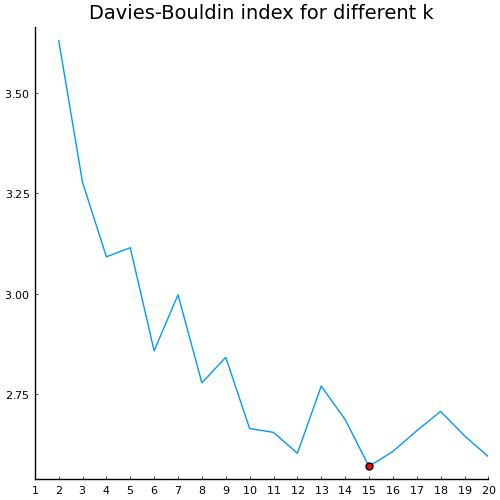

In [28]:
plot(collect(2:20), DBs)
scatter!((collect(2:20)[findmin(DBs)[2]],findmin(DBs)[1]),  markersize  = 5, color = :red)
plot!(legend = false, title = "Davies-Bouldin index for different k",
                grid = false, size = (500,500),
                xticks = 1:20, xlims = (1,20))

In [32]:
d = pairwise(Euclidean(), images, images);

In [30]:
scores = []
for k = 2:20
    assigment, _, _ = kmeans(images',k, plotting = false);
    push!(scores, mean(silhouettes(assigment,d)))
end

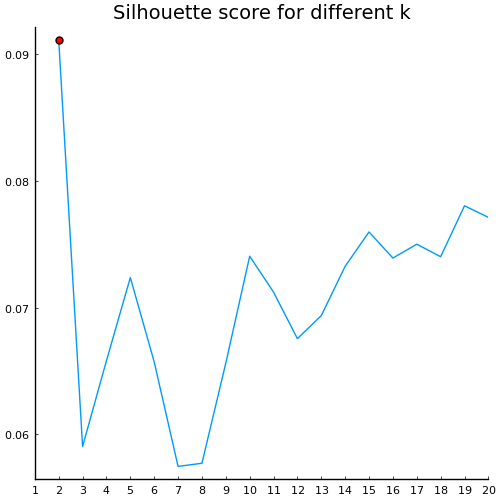

In [31]:
plot(collect(2:20), scores)
scatter!((collect(2:20)[findmax(scores)[2]],findmax(scores)[1]),  markersize  = 5, color = :red)
plot!(legend = false, title = "Silhouette score for different k",
                grid = false, size = (500,500),
                xticks = 1:20, xlims = (1,20))

## Grupowanie hierarchiczne

Zbiorcza nazwa metod w obrębie analizy skupień, w których tworzone kolejno klastry pozostają w pewnej hierarchii. W tej hierarchii można wyszczególnić grupy (klastry) nadrzędne, których elementami są inne grupy (klastry) niższego rzędu. Metody te są deterministyczne - dają gwarancję powtarzalności wyników dla tych samych danych wejściowych. 

Metody ze względu na sposób grupowania dzielą się na: 
- <b>metody aglomeracyjne</b> (indukcyjne)
- <b>metody podziałowe</b> (dedukcyjne)


W metodach aglomeracyjnych punktem startowym jest zbiór jednoelementowych klastrów, którego liczba elementów jest równa liczbie obiektów. W każdym kolejnym kroku obiekty są łączone w skupiska wyższego rzędu na podstawie wybranej metryki odległości pomiędzy grupami. Efektem końcowym jest jedna grupa obiektów zawierająca wszystkie elementy zbioru. Metody podziałowe postępują w sposób odwrotny: stanem początkowym jest jedna grupa, zawierająca wszystkie obiekty, która jest w kolejnych krokach dzielona na coraz mniejsze elementy, aż do uzyskania zbioru skupisk jednoelementowych. 

W odróżnieniu od innych metod grupowania (np. k-means), metody klastrowania hierarchicznego nie wymagają ustalania z góry liczby klastrów. Oznacza to, że po przeprowadzeniu procedury i zwizualizowaniu jej wyników np. za pomocą dendrogramu, badacz może po fakcie, na podstawie wyników zadecydować, jaka liczba klastrów jest optymalna. Zwykle podział następuje w miejscu najdłuższych gałęzi dendrogramu. 


Do najpopularniejszych metod hierarchicznych należą:

- metoda Warda (odległość pomiędzy grupami jest sumą kwadratów odchyleń od punktów do centroidów)
- metoda najdalszego sąsiedztwa (odległość pomiędzy grupami jest ustalona jako odległość pomiędzy najbardziej oddalonymi od siebie obiektami z dwóch grup)
- metoda najbliższego sąsiedztwa (odległość pomiędzy grupami jest ustalona jako odległość pomiędzy najmniej oddalonymi od siebie obiektami z dwóch grup)
- metoda średniej grupowej (odległość pomiędzy grupami jest ustalona jako średnia wszystkich odległości pomiędzy obiektami różnych grup)
- metoda mediany (odległość pomiędzy grupami jest ustalona jako mediania odległości pomiędzy obiektami różnych grup)
- metoda środka ciężkości (odległość pomiędzy grupami jest ustalona jako odległość pomiędzy centroidami różnych grup)

In [33]:
D = pairwise(Euclidean(), X', X');

In [34]:
hclusters = hclust(D, linkage = :ward)

Hclust{Float64}([-138 -191; -8 -92; … ; 295 297; 296 298], [0.002124093707314633, 0.00294536298119817, 0.0039553871862665, 0.005002100143706605, 0.0068894152724054145, 0.007649692687101338, 0.011826527507761295, 0.012738151699512215, 0.015348022191008765, 0.016461674995586827  …  2.1965269088369026, 2.4383917871255902, 2.4780011069788417, 2.646256006741765, 2.7161440410848723, 3.086000056033909, 3.570889294109607, 3.6168387124175543, 13.890986485484362, 18.232050177176188], [254, 240, 294, 260, 280, 297, 236, 293, 255, 258  …  170, 147, 156, 127, 112, 178, 168, 139, 108, 150], :ward)

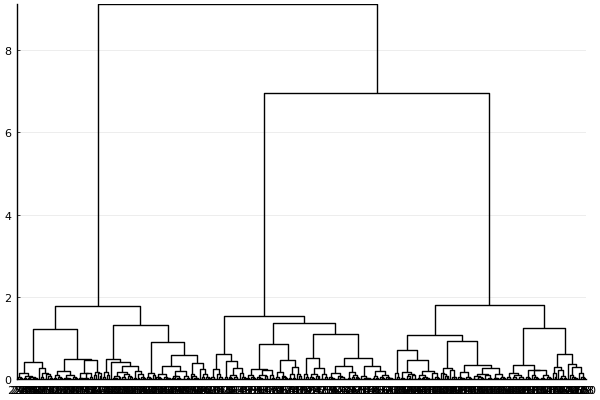

In [35]:
plot(hclusters)

In [36]:
clus_res = cutree(hclusters,k = 3);

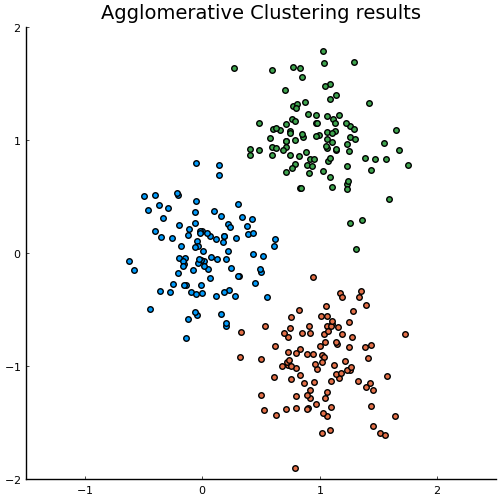

In [37]:
p = scatter()
for i = 1:3
    group = X[clus_res .== i, :]
    scatter!(group[:,1], group[:,2])
end
plot!(legend = false, title = "Agglomerative Clustering results",
        grid = false, size = (500,500),
         xlims = (-1.5,2.5), ylims = (-2,2))

## Metody gęstościowe (DBSCAN)

Metody gęstościowe poza odległością pomiędzy punktami do analizy dodają pojęcie gęstości. Oopierają się na prostej obserwacji - węwnątrz klastrów gęstość punktów jest większa niż poza nimi.

Do uruchomienia takiego algorytmu potrzebujemy dwóch parametrów: 
- $\epsilon$ - maksymalny promień sąsiedztwa
- <i>MinPts</i>- minimalna liczba punktów w klastrze definiowanym przez $\epsilon$


W ramach wyodrębnionego przez algorytm DBSCAN klastra możemy wyróżnić następujące typy punktów:

- </b>Rdzeń</b> punkt spełniający warunek taki, że w sąsiedztwie wyznaczonym przez $\epsilon$ znajduje się co najmniej <i>MinPts</i> punktów
- <b>Punkt graniczny</b> punkt nie będący rdzeniem ale osiągalny z innego rdzenia
- <b>Szum (obserwacja odstająca)</b> punkt nie będący ani rdzeniem ani punktem odstającym

[![DBSCAN](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/600px-DBSCAN-Illustration.svg.png)](https://en.wikipedia.org/wiki/DBSCAN)

Do zalet takiej metody należy to, że jest w stanie wyznaczyć klastry o dowolnym kształcie:

[![DBSCAN](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/DBSCAN-density-data.svg/480px-DBSCAN-density-data.svg.png)](https://en.wikipedia.org/wiki/DBSCAN)

Ponadto nie wymaga definiowania z góry ilości klastrów których poszukujemy oraz pozwala na usunięcie z badanego zbioru obserwacji odstających.

Niestety metoda ma też wady:

- jest wrażliwa na zastosowaną miarę odległości i kolejność procesowania punktów
- gdy nie znamy danych dobór odpowiednich wartości parametrów jest trudny
- $\epsilon$ i <i>MinPts</i> są zadane z góry i stałe dla wszystkich klastrów; w wielu sytuacjach gęstość zbiorów jest zależna od specyfiki danego klastra i powinna być ustalona niezależnie od pozostałych klastrów

In [38]:
dclusters = dbscan(D, 0.20, 5)

DbscanResult([1, 101, 201], [1, 1, 1, 1, 1, 1, 0, 1, 1, 0  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [88, 90, 94])

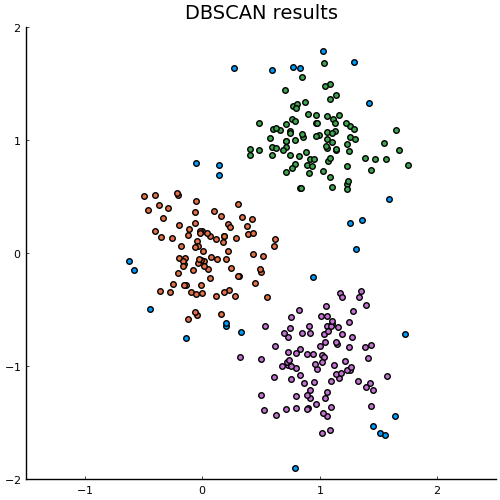

In [39]:
p = scatter()
for i = 0:3
    group = X[dclusters.assignments .== i, :]
    scatter!(group[:,1], group[:,2])
end
plot!(legend = false, title = "DBSCAN results",
        grid = false, size = (500,500),
         xlims = (-1.5,2.5), ylims = (-2,2))

## Analiza głównych składowych (PCA)

Patrząc na przykład MNISTa widzimy, że klasteryzacja  zmiennych może problematyczna:
- przy dużej liczbie parametrów nie wiemy, które z nich odgrywają znaczącą rolę przy klasteryzacji a które są jedynie szumem.
- dodatkowo czas liczenia zaczyna być znaczący.

Dlatego w przypadku wielu rozbudowanych zbiorów tym co nas interesuje jest redukcja jego wymiarów poprzez usuwanie niepotrzebnych (w niewielkim stopniu tłumaczącym zmienność zbioru) zmiennych. Jedną z metod, która pozwala to osiągnąć jest <b>analiza głównych składowych</b> (<i>principal component analysis</i>, PCA).

Jej działanie polega na takim obrocie układu współrzędnych (dokładniej przekształceniu unitarnym wektorów), które doprowadzi do sytuacji, w której pierwsza współrzędna będzie tłumaczyła możliwie największy odsetek wariancji, druga drugi w kolejności odsetek, etc. W ten sposób konstruowana jest nowa przestrzeń obserwacji, w której najwięcej zmienności wyjaśniają początkowe czynniki.

PCA jest często używana do zmniejszania rozmiaru zbioru danych statystycznych, poprzez odrzucenie ostatnich czynników. Można też poszukać merytorycznej interpretacji czynników, zależnej od rodzaju danych, co pozwala lepiej zrozumieć naturę danych, choć bywa trudne przy większej liczbie badanych zmiennych. W przetwarzaniu sygnałów PCA jest używana np. do kompresji sygnału. 

In [40]:
Y = hcat(X,randn(300), rand(300));

In [41]:
Y

300×4 Matrix{Float64}:
  0.179209     0.097991   -0.274806   0.141496
  0.0146231   -0.0721008  -0.253666   0.213878
 -0.27735     -0.33989    -0.10866    0.647232
 -0.35614     -0.332507   -0.181216   0.234703
 -0.047561    -0.548432    0.384499   0.491639
 -0.00536625   0.200676   -0.305251   0.641962
  0.331721    -0.694219   -0.447663   0.201191
  0.182984     0.150485   -0.197362   0.511475
  0.387596     0.171007   -1.28713    0.983326
  0.197844    -0.643327    1.0791     0.763792
 -0.331417     0.315829    1.45175    0.784064
  0.277481    -0.378712    1.37357    0.621948
 -0.246027    -0.276322   -0.16171    0.827143
  ⋮                                   
  1.01564     -0.965632    2.19408    0.408706
  1.45547     -1.20642    -0.930172   0.0819437
  0.318739    -0.91437     1.82825    0.273926
  1.07353     -0.687822   -0.373992   0.342459
  1.09938     -0.642615    0.6334     0.0685184
  1.01183     -0.559359   -0.0606698  0.311699
  1.2524      -0.609738    0.171197   0.549

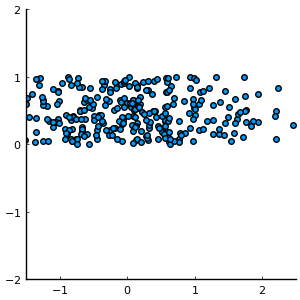

In [42]:
scatter(Y[:,3], Y[:,4])
plot!(legend = false, grid = false, size = (300,300),xlims = (-1.5,2.5), ylims = (-2,2))

W takim razie jak wygląda procedura PCA?

Mamy zadaną macierz $X$ o wymiarach $N \times n$ gdzie $N$ wierszy oznacza obserwacje a $n$ kolumn parametry je opisujące. Interesuje nas znalezienie takiego zbioru $n-$wymiarowych wektorów jednostkowych $w_{(k)} = (w_1,w_2,\dots,w_p)_{(k)}$, który umożliwi nam przeskalowanie wierszy macierzy $X$ $x_{(i)}$ do postaci nowego wektora $t_{(i)}= (t_1,t_2,\dots,t_l)_{(i)}$, takiego, że wariancja każdego kolejnego $t$ będzie najwyższą możliwą wariancją w $X$.

PCA jest wrażliwe na skalowanie zmiennych, w pierwszym kroku należy więc znormalizować dane:

In [43]:
centre(x) = broadcast(-, x, mean(x, dims = 1))

centre (generic function with 1 method)

W następnym kroku należy wyznaczyć macierz kowariancji $Cov(X,X)$ i wyznaczyć jej wartości własne. W tym kroku można przeprowadzić redukcję wymiarowości modelu - wielkość wartości własnej mówi nam o tym jak słabo skorelowana jest dana zmienna z pozostałymi zmiennymi, czyli o tym jak mocno dana cecha tłumaczy zmienność obserwacji.

Następnie należy wyznaczyć wektory własne (na bazie wybranych wartości własnych) i dokonać projekcji $X$, korzystając z wyznaczonych wektorów własnych, w celu otrzymania obserwacji w nowej przestrzeni.

Zaimplementujmy funkcję:

In [44]:
function pca(X)
    U, S, V  = LinearAlgebra.svd(centre(X))
    T = U * Diagonal(S)
    w = StatsBase.var(T,dims = 1)/sum(StatsBase.var(T,dims = 1))
    return T,w
end

pca (generic function with 1 method)

In [45]:
T,w = pca(Y);

LoadError: LAPACKException(3)

In [46]:
w

LoadError: UndefVarError: w not defined

I wróćmy do MNISTa:

In [47]:
T,w = pca(images');

In [48]:
w

1×784 Matrix{Float64}:
 0.100095  0.0746062  0.0646369  0.0551523  …  3.52242e-35  4.08793e-36

In [49]:
sum(w .> 0.01)

21

In [50]:
sum(w[1:21])

0.6675710772722219

In [51]:
@time assigment, centroids, convergence = kmeans(T[:,1:2],10);

 94.180733 seconds (620.92 M allocations: 57.398 GiB, 19.08% gc time, 0.58% compilation time)


In [52]:
cluster_labels, ARI , _ = check_clustering(assigment,labels);

In [53]:
ARI

0.0

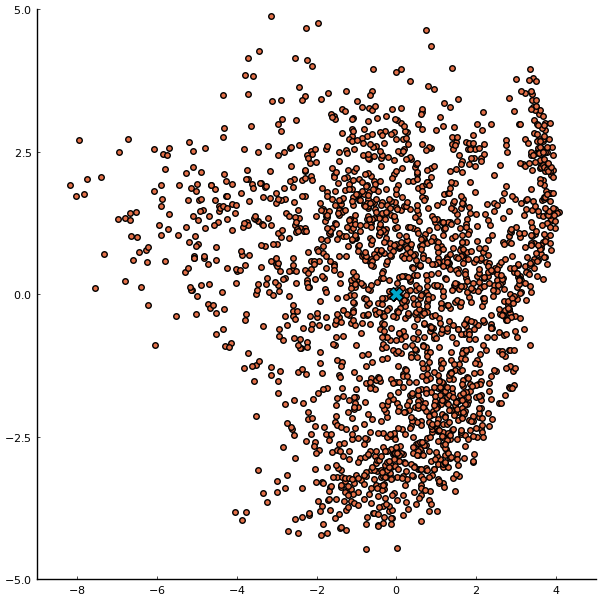

In [54]:
p = scatter()
for j = 1:10
    group = T[assigment .== j, :]
    scatter!(group[:,1], group[:,2])
end
scatter!(centroids[:,1], centroids[:,2], shape = :X, markersize  = 10)
plot!(legend = false, 
    grid = false, size = (600,600),
    xlims = (-9,5), ylims = (-5,5))          

### Dodatkowa praca domowa

1. Zmodyfikuj implementację algorytmu <i>k-means</i> tak aby na wejściu przyjmowała listę wektorów a nie macierz i  później pracowała na danych w tym formacie. Sprawdź czy poprawi to wydajność działania <b>(10 punktów)</b>.

2. Uruchom algorytmy grupowania hierarchicznego i DBSCAN na danych ze zbioru MNIST. Wybierz najlepsze wartości ich parametrów wejściowych. Wyznacz dla nich wynik ARI i AMI. Który z trzech omawianych algorytmów daje najlepszy rezultat? <b>(10 punktów)</b>